In [ ]:
# Trying to work out shift in NuSTAR to match an AIA image at 23:40
# 
# Just doing in for FPMA
# 
# 30-Oct-2022 IGH

In [5]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.time as atime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from sunpy.net import Fido, attrs as a
from sunpy.map import Map
import glob
import pandas as pd
import nustar_pysolar as nustar
from scipy import ndimage

import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from sunpy.coordinates import Helioprojective

from aiapy.calibrate import register, update_pointing, normalize_exposure

import warnings
warnings.simplefilter('ignore')

from pathlib import Path

In [10]:
maindir=str(Path.home())+'/data/heasarc_nustar/ns_20220603/'
nsids=[str(20627001001+i*1000) for i in range(25)]
nsid=nsids[0]
print(nsid)

20627001001


In [12]:
# Function to convert chu info into something more readable

def make_chu(maindir,nsid):
    fca=maindir+nsid+'/hk/nu'+nsid+'_chu123.fits'

    clist = fits.open(fca)
    cdata1=clist[1].data
    cdata2=clist[2].data
    cdata3=clist[3].data
    chdr = clist[1].header
    clist.close()

    mjdref=atime.Time(chdr['mjdrefi'],format='mjd')

    ctims=atime.Time(mjdref+cdata3['time']*u.s,format='mjd')
        
    maxres=20
    c1mask=np.all([[cdata1['valid'] == 1],[cdata1['residual'] < maxres],\
                    [cdata1['starsfail'] < cdata1['objects']],[cdata1['chuq'][:,3] != 1]],axis=0)

    c1mask=c1mask[0]*1
    c2mask=np.all([[cdata2['valid'] == 1],[cdata2['residual'] < maxres],\
                    [cdata2['starsfail'] < cdata2['objects']],[cdata2['chuq'][:,3] != 1]],axis=0)
    c2mask=(c2mask[0]*4)
    c3mask=np.all([[cdata3['valid'] == 1],[cdata3['residual'] < maxres],\
                    [cdata3['starsfail'] < cdata3['objects']],[cdata3['chuq'][:,3] != 1]],axis=0)
    c3mask=(c3mask[0]*9)
    mask=c1mask+c2mask+c3mask

    newmask=np.zeros(len(mask))
    newmask[np.where(mask ==1)]=1
    newmask[np.where(mask ==4)]=2
    newmask[np.where(mask ==5)]=3
    newmask[np.where(mask ==9)]=4
    newmask[np.where(mask ==10)]=5
    newmask[np.where(mask ==13)]=6
    newmask[np.where(mask ==14)]=7
    #     just to get rid of weird stuff
    newmask[np.where(mask ==0)]=np.nan

    maskid=np.zeros(len(newmask))
    chus=np.unique(newmask)

    chuids=np.array([0,1,2,12,3,13,23,123,0])

    for c in chus:
        maskid[newmask == c]=chuids[int(c)]

    return ctims,newmask,maskid

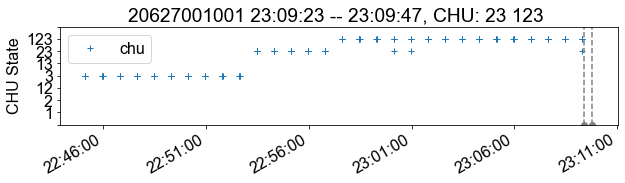

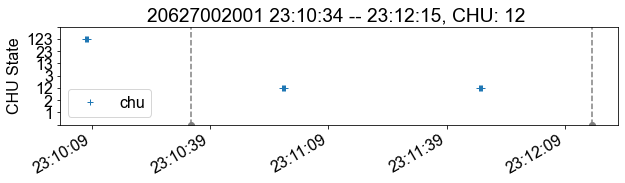

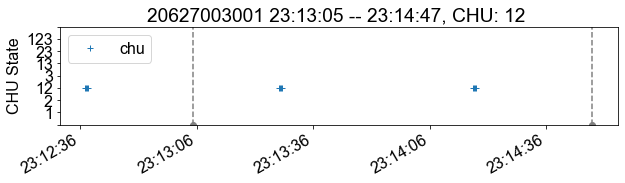

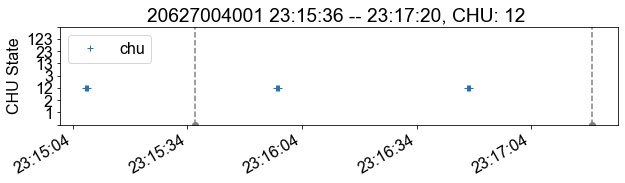

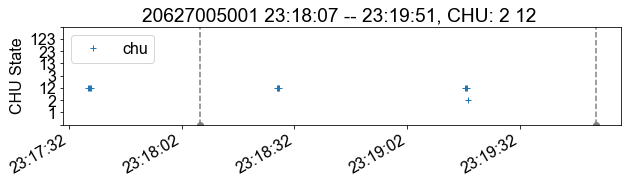

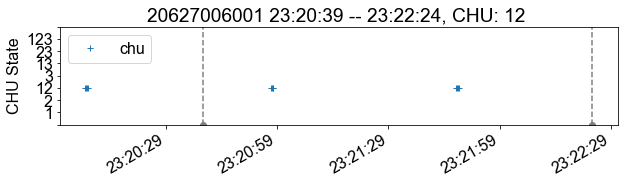

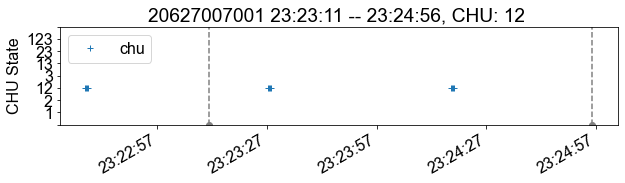

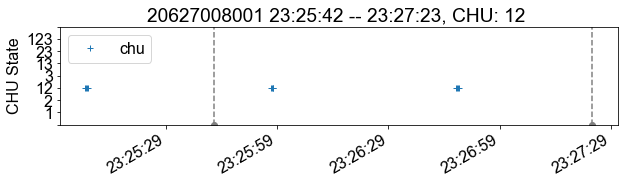

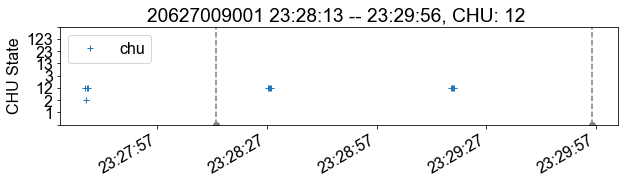

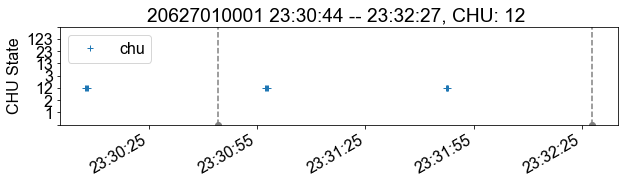

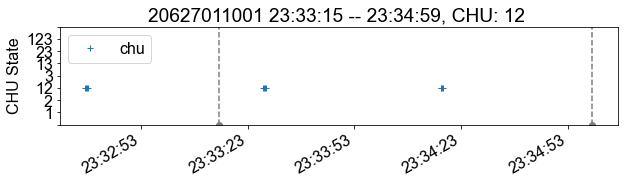

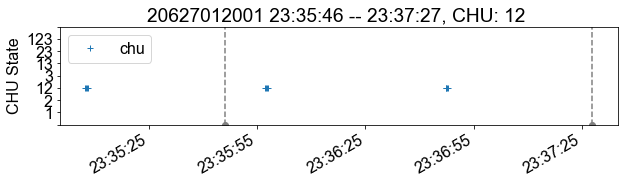

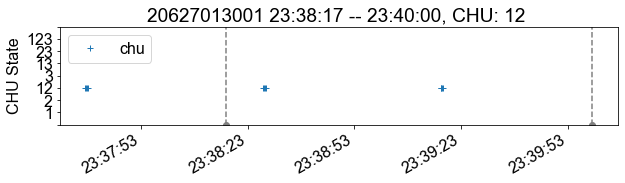

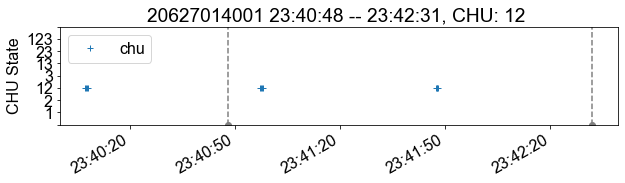

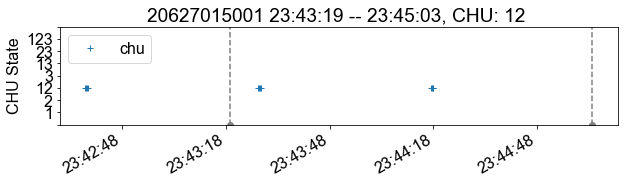

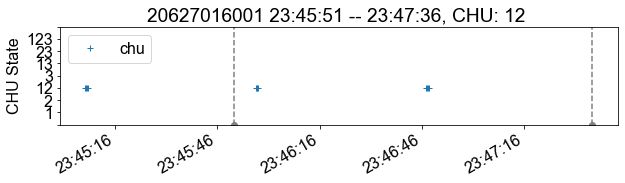

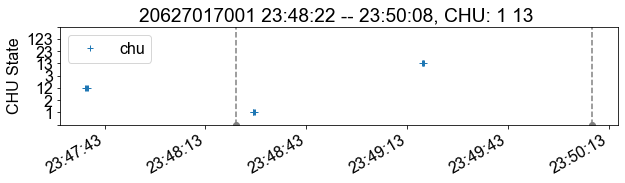

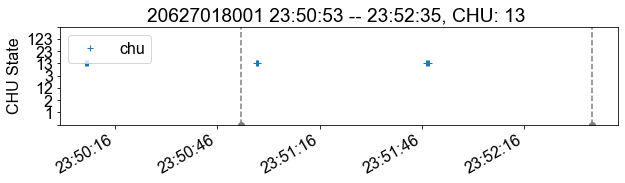

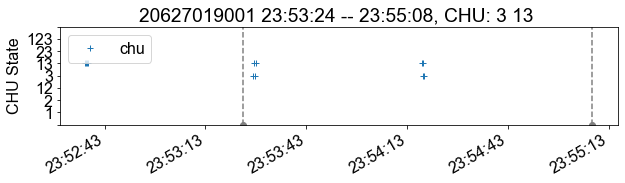

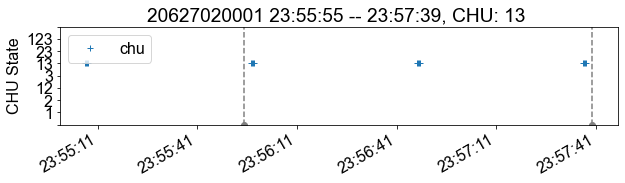

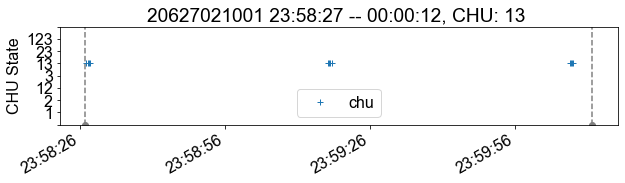

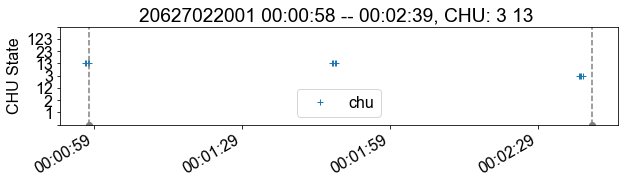

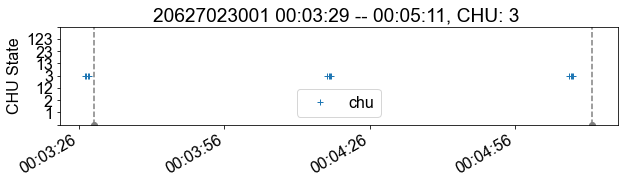

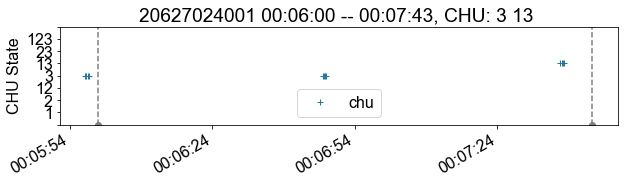

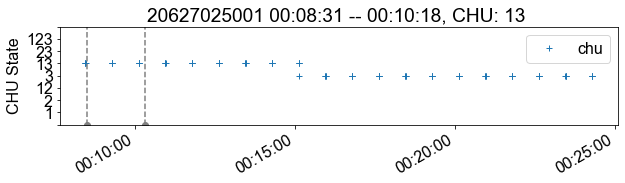

In [13]:
# Find the CHU per mosaic tile

myFmt = dates.DateFormatter('%H:%M:%S')
majorx= dates.SecondLocator(interval=30)
majorx2= dates.MinuteLocator(interval=5)
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                    'font.sans-serif':"Arial",'mathtext.default':"regular"})

chus=[]

for i in range(25):
    nsid=nsids[i]
    ctims,newmask,maskid=make_chu(maindir,nsids[i])

    dft=pd.DataFrame({'chu':newmask,'maskid':maskid},index=ctims.datetime)    
    
    hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
    evtdata=hdulist[1].data
    hdr = hdulist[1].header
    hdulist.close()
    mjdref=hdr['MJDREFI']
    t1 = atime.Time(mjdref*u.d+min(evtdata['time'])*u.s, format = 'mjd')
    t2 = atime.Time(mjdref*u.d+max(evtdata['time'])*u.s, format = 'mjd')

    lowert=t1-10*u.second
    dftt=dft.truncate(lowert.isot,t2.isot)
    
    chu_thispnt=np.unique(dftt["maskid"].values)
    chus.append(chu_thispnt)
    chustr='CHU: '
    for c in chu_thispnt:
        chustr=chustr+str(int(c))+' '
    
    fig = plt.figure(figsize=(10,2))
    ax= fig.add_subplot(111)
    dft.plot(y='chu',marker='+',linestyle='none',ax=ax)
    # ax.plot_date(ctims.datetime, newmask, color='darkgoldenrod',marker='+',mew=2,ms=7)
    ax.set_yticklabels([' ','1','2','12','3','13','23','123',' '])
    ax.set_ylabel('CHU State')
    ax.set_ylim([0,8])
    ax.set_title(nsid+' '+t1.isot[11:19]+' -- '+t2.isot[11:19]+', '+chustr)
    ax.locator_params(axis="y", nbins=9)
    # ax.set_xlim([min_date,max_date])
    if (i == 0) or (i ==24):
        ax.xaxis.set_major_locator(majorx2)
    else:
        ax.xaxis.set_major_locator(majorx)
    ax.xaxis.set_major_formatter(myFmt)
    ax.plot_date([t1.datetime,t1.datetime],[0,10],linestyle='--',color='grey')
    ax.plot_date([t2.datetime,t2.datetime],[0,10],linestyle='--',color='grey')
    plt.show()  

In [14]:
# What are the CHUS per mosaic tile?
for i in range(len(chus)):
    print('MOS',i+1,' --',chus[i])

MOS 1  -- [ 23. 123.]
MOS 2  -- [12.]
MOS 3  -- [12.]
MOS 4  -- [12.]
MOS 5  -- [ 2. 12.]
MOS 6  -- [12.]
MOS 7  -- [12.]
MOS 8  -- [12.]
MOS 9  -- [12.]
MOS 10  -- [12.]
MOS 11  -- [12.]
MOS 12  -- [12.]
MOS 13  -- [12.]
MOS 14  -- [12.]
MOS 15  -- [12.]
MOS 16  -- [12.]
MOS 17  -- [ 1. 13.]
MOS 18  -- [13.]
MOS 19  -- [ 3. 13.]
MOS 20  -- [13.]
MOS 21  -- [13.]
MOS 22  -- [ 3. 13.]
MOS 23  -- [3.]
MOS 24  -- [ 3. 13.]
MOS 25  -- [13.]


In [7]:
# MOS 1 -> CHU123 shift
# MOS2 - 16 -> CHU12 shift
# MOS17 - 25 -> CHU13 shift?
#  or MOS 19, 22, 23, 24 -> CHU3 shift

In [15]:
# Now want to just load in and plot submap for each mosaic
# so need to know centre of each pointing - probably many ways to do
# this but already have this info in my summary files

# From https://github.com/ianan/nsigh_all/blob/master/info_files/ns_20220603_info.csv
xcs=np.array([1090,957,827, 706, 610, 175, \
    333, 436, 549, 672, 232, 102, -23, -143, \
        -251, -674, -581, -446,-330, -192, -647, -758, -883, -954,-1072])
ycs=np.array([522, 153, -256, -630, -1087, \
    -982, -566, -195, 251, 687, 800, 372, -65, \
        -455, -854, -738, -357, 60, 483, 903, 1004, 571, 153, -310, -660])

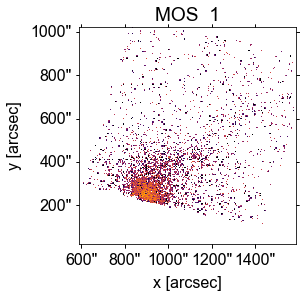

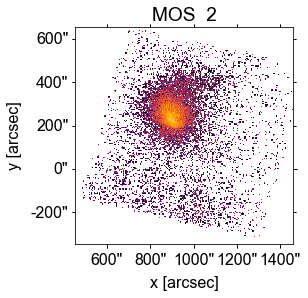

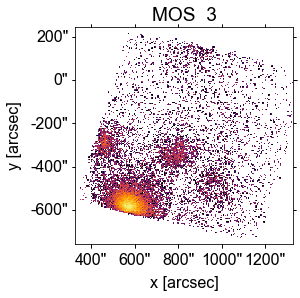

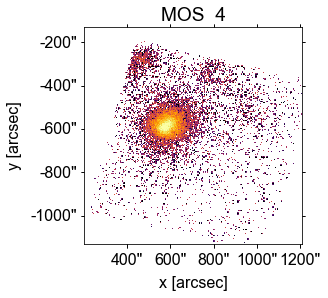

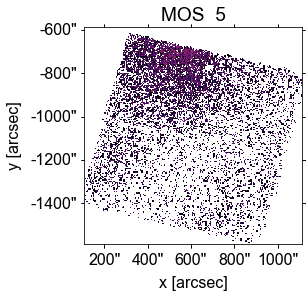

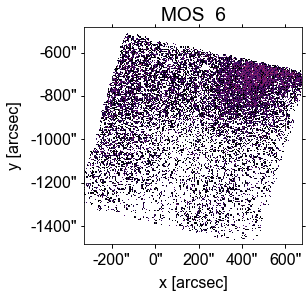

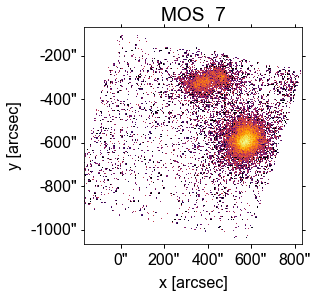

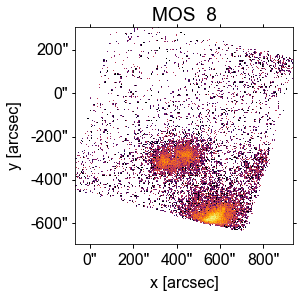

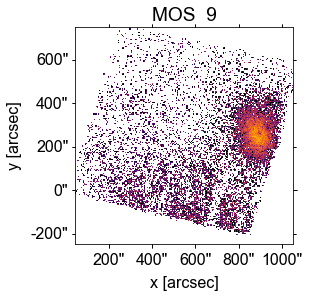

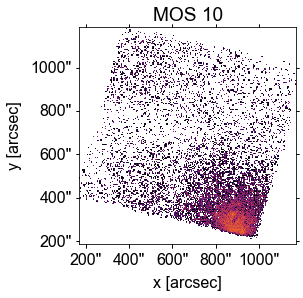

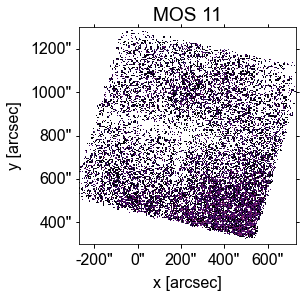

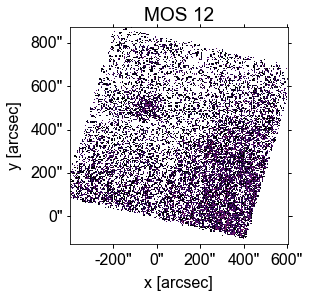

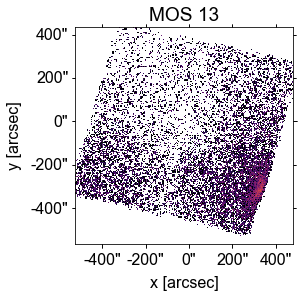

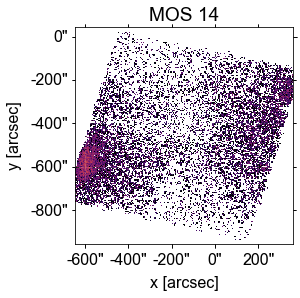

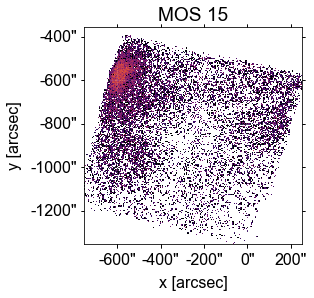

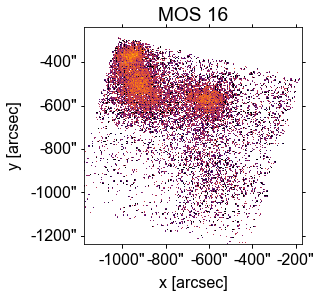

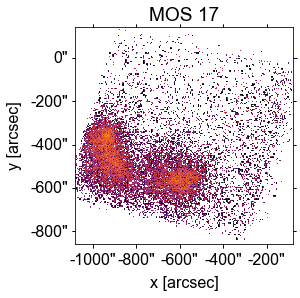

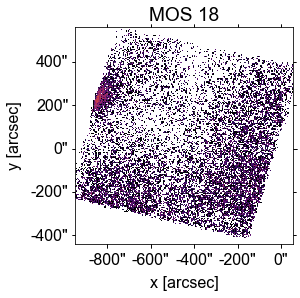

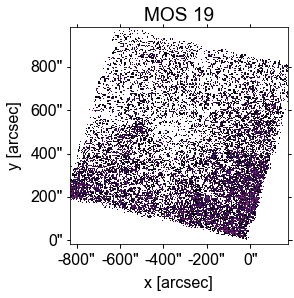

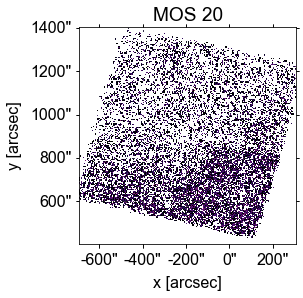

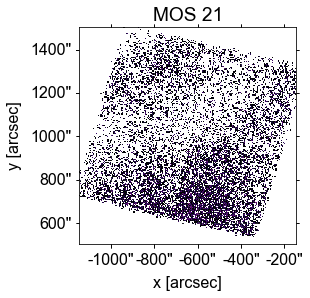

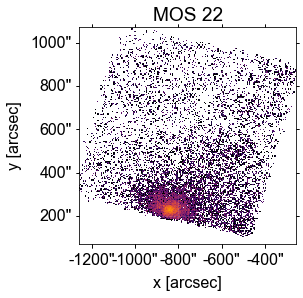

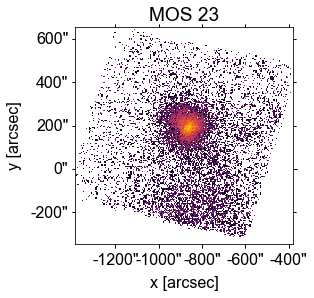

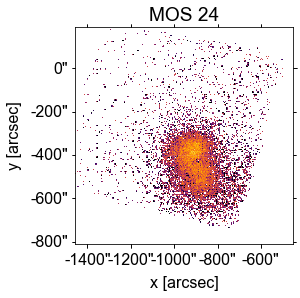

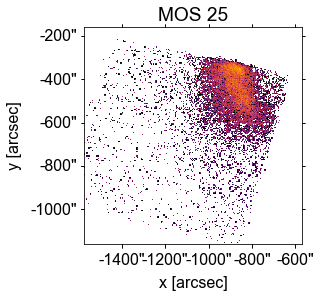

In [16]:
# Plot all mosaic tiles just to check them
wid=1000

for i in range(25):
    nsid=nsids[i]
    hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
    evtdata=hdulist[1].data
    hdr = hdulist[1].header
    hdulist.close()

    cevt0 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0)
    nmap0 = nustar.map.make_sunpy(cevt0, hdr,norm_map=True)
    bl=np.array([xcs[i]-0.5*wid,ycs[i]-0.5*wid])
    tr=np.array([xcs[i]+0.5*wid,ycs[i]+0.5*wid])
    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nmap0.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nmap0.coordinate_frame)
    snm = nmap0.submap(bottom_left, top_right=top_right)
    snmr=snm.resample([300, 300] * u.pixel)

    fig = plt.figure(figsize=(5, 4))
    ax = plt.subplot(projection=snmr)
    snmr.plot(norm=colors.LogNorm(vmin=1e-2,vmax=1e1),cmap='inferno')
    # plt.colorbar(fraction=0.035, pad=0.03,label='count/s')
    ax.set_ylabel('y [arcsec]')
    ax.set_xlabel('x [arcsec]')
    ax.set_title(f'MOS {i+1:2d}')
    plt.show()

In [18]:
# Load in AIA file for alignment - here using previously made 131A
amm=Map('fin_fits/AIA_1200_2000_10131.fits')

# When plot what NuSTAR contours to do
cnt_lvl=[2,10,30,50,70]

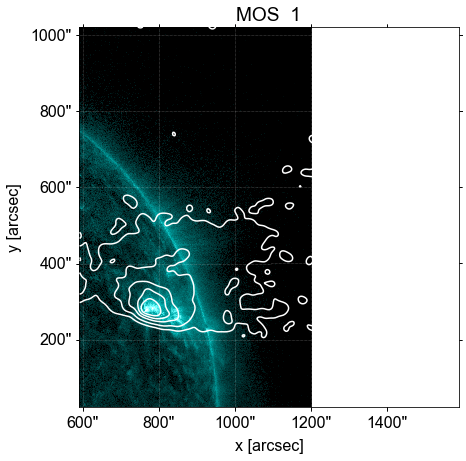

In [19]:
# chu123 shift
shx=-120
shy=35
i=0
wid=1000

nsid=nsids[i]
hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
evtdata=hdulist[1].data
hdr = hdulist[1].header
hdulist.close()
pxs=abs(hdr['TCDLT14'])
shevtx=round(shx/pxs)
shevty=round(shy/pxs)
evtdata['x']+=shevtx
evtdata['y']+=shevty

cevt0 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0)
nmap0 = nustar.map.make_sunpy(cevt0, hdr,norm_map=True)
bl=np.array([xcs[i]-0.5*wid,ycs[i]-0.5*wid])
tr=np.array([xcs[i]+0.5*wid,ycs[i]+0.5*wid])
bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nmap0.coordinate_frame)
top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nmap0.coordinate_frame)
snm = nmap0.submap(bottom_left, top_right=top_right)
dd=ndimage.gaussian_filter(snm.data, 4, mode='nearest')
snmd=Map(dd, snm.meta)
# snmr=snm.resample([300, 300] * u.pixel)

bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=amm.coordinate_frame)
top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=amm.coordinate_frame)
samm = amm.submap(bottom_left, top_right=top_right)

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(projection=samm)
samm.plot(norm=colors.PowerNorm(0.5,vmin=1,vmax=1e2))
with Helioprojective.assume_spherical_screen(snmd.observer_coordinate):
    snmd.draw_contours(levels=cnt_lvl*u.percent, axes=ax, colors='white')

# snmd.draw_contours(levels=cnt_lvl*u.percent, axes=ax, colors='white')
ax.set_ylabel('y [arcsec]')
ax.set_xlabel('x [arcsec]')
ax.set_title(f'MOS {i+1:2d}')
plt.show()

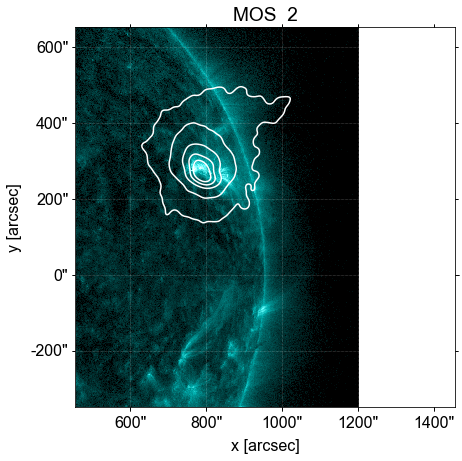

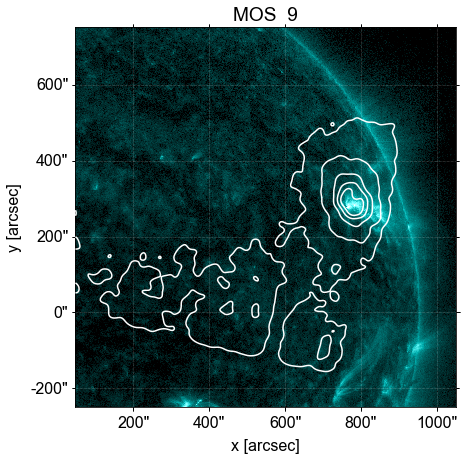

In [20]:
# CHU12 shift - 2,9 need something different
wid=1000
shx=-110
shy=45
ids=np.array([2,9])-1
for i in ids:
    nsid=nsids[i]
    hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
    evtdata=hdulist[1].data
    hdr = hdulist[1].header
    hdulist.close()
    pxs=abs(hdr['TCDLT14'])
    shevtx=round(shx/pxs)
    shevty=round(shy/pxs)
    evtdata['x']+=shevtx
    evtdata['y']+=shevty

    cevt0 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0)
    nmap0 = nustar.map.make_sunpy(cevt0, hdr,norm_map=True)
    bl=np.array([xcs[i]-0.5*wid,ycs[i]-0.5*wid])
    tr=np.array([xcs[i]+0.5*wid,ycs[i]+0.5*wid])
    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nmap0.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nmap0.coordinate_frame)
    snm = nmap0.submap(bottom_left, top_right=top_right)
    dd=ndimage.gaussian_filter(snm.data, 4, mode='nearest')
    snmd=Map(dd, snm.meta)
    # snmr=snm.resample([300, 300] * u.pixel)

    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=amm.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=amm.coordinate_frame)
    samm = amm.submap(bottom_left, top_right=top_right)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(projection=samm)
    samm.plot(norm=colors.PowerNorm(0.5,vmin=1,vmax=1e2))
    with Helioprojective.assume_spherical_screen(snmd.observer_coordinate):
        snmd.draw_contours(levels=cnt_lvl*u.percent, axes=ax, colors='white')
    ax.set_ylabel('y [arcsec]')
    ax.set_xlabel('x [arcsec]')
    ax.set_title(f'MOS {i+1:2d}')
    plt.show()

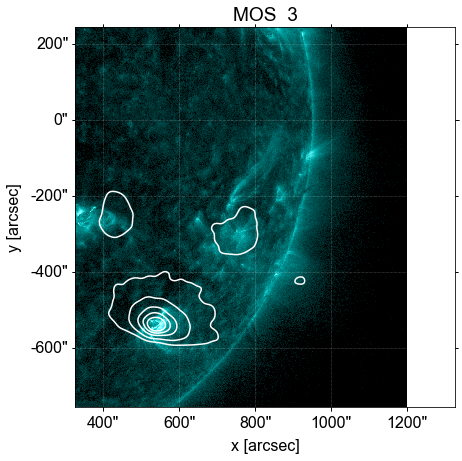

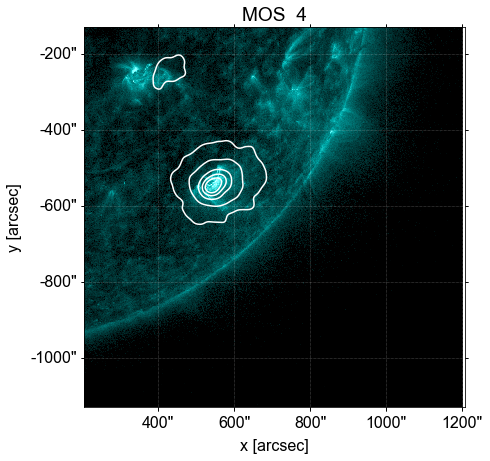

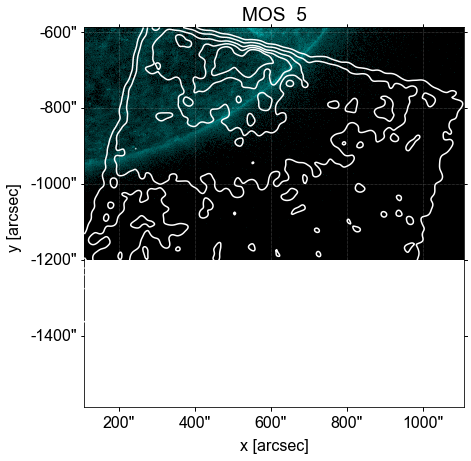

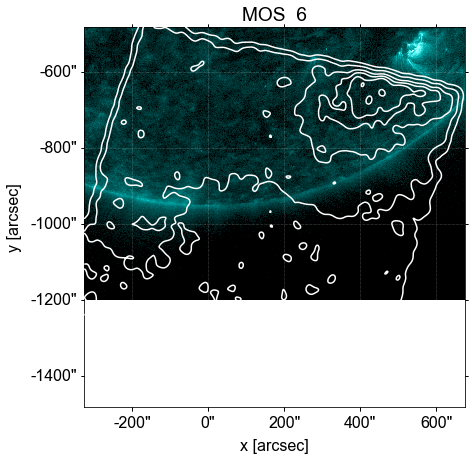

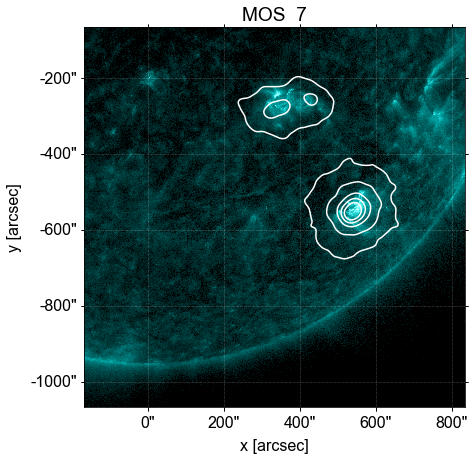

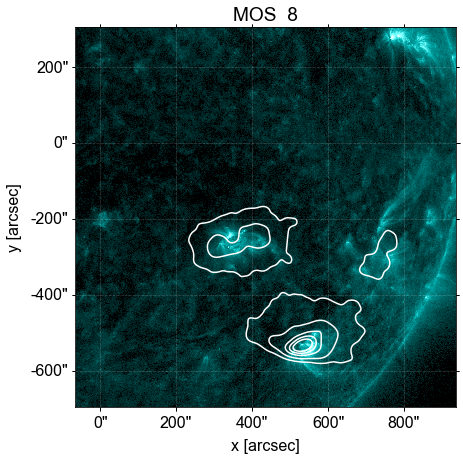

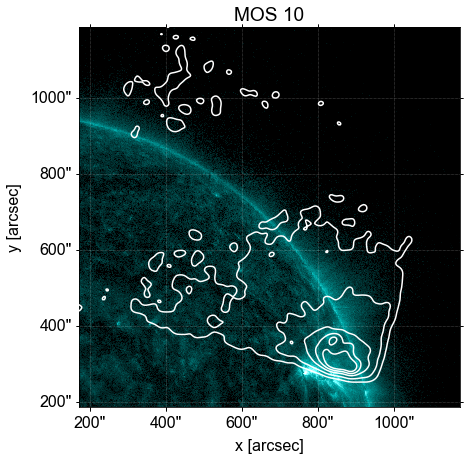

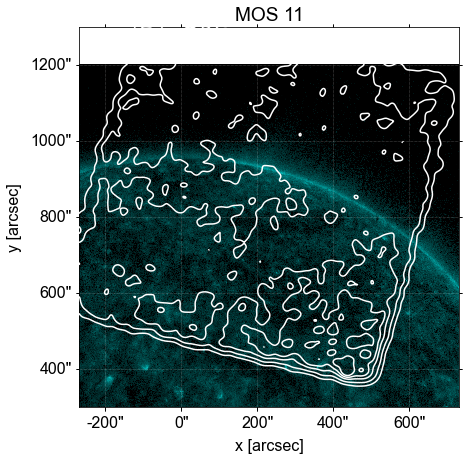

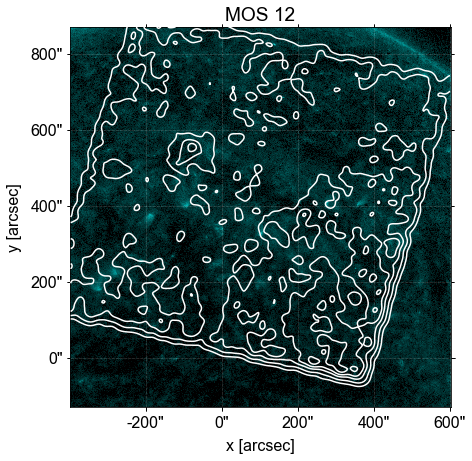

In [21]:
# CHU12 shift
wid=1000
shx=-35
shy=45
ids=np.array([3,4,5,6,7,8,10,11,12])-1
for i in ids:
    nsid=nsids[i]
    hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
    evtdata=hdulist[1].data
    hdr = hdulist[1].header
    hdulist.close()
    pxs=abs(hdr['TCDLT14'])
    shevtx=round(shx/pxs)
    shevty=round(shy/pxs)
    evtdata['x']+=shevtx
    evtdata['y']+=shevty

    cevt0 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0)
    nmap0 = nustar.map.make_sunpy(cevt0, hdr,norm_map=True)
    bl=np.array([xcs[i]-0.5*wid,ycs[i]-0.5*wid])
    tr=np.array([xcs[i]+0.5*wid,ycs[i]+0.5*wid])
    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nmap0.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nmap0.coordinate_frame)
    snm = nmap0.submap(bottom_left, top_right=top_right)
    dd=ndimage.gaussian_filter(snm.data, 4, mode='nearest')
    snmd=Map(dd, snm.meta)
    # snmr=snm.resample([300, 300] * u.pixel)

    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=amm.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=amm.coordinate_frame)
    samm = amm.submap(bottom_left, top_right=top_right)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(projection=samm)
    samm.plot(norm=colors.PowerNorm(0.5,vmin=1,vmax=1e2))
    with Helioprojective.assume_spherical_screen(snmd.observer_coordinate):
        snmd.draw_contours(levels=cnt_lvl*u.percent, axes=ax, colors='white')
    ax.set_ylabel('y [arcsec]')
    ax.set_xlabel('x [arcsec]')
    ax.set_title(f'MOS {i+1:2d}')
    plt.show()

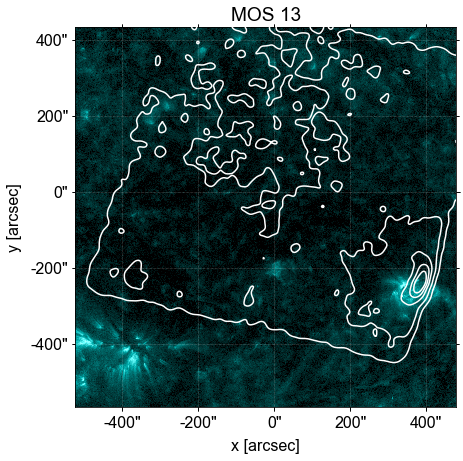

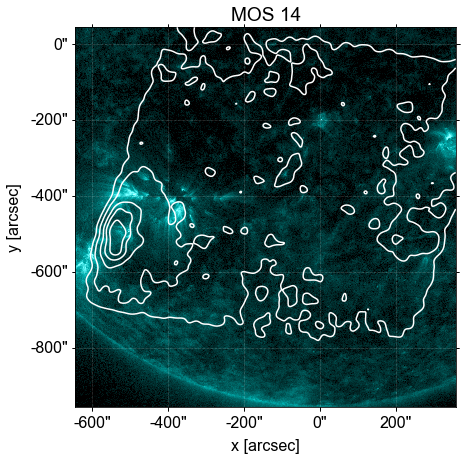

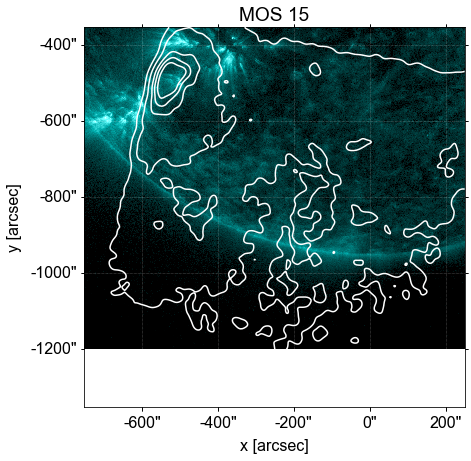

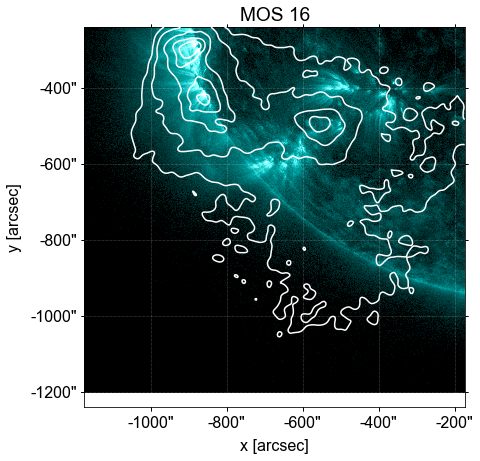

In [22]:
# CHU12 shift
wid=1000
shx=60
shy=80
ids=np.array([13,14,15,16])-1
for i in ids:
    nsid=nsids[i]
    hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
    evtdata=hdulist[1].data
    hdr = hdulist[1].header
    hdulist.close()
    pxs=abs(hdr['TCDLT14'])
    shevtx=round(shx/pxs)
    shevty=round(shy/pxs)
    evtdata['x']+=shevtx
    evtdata['y']+=shevty

    cevt0 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0)
    nmap0 = nustar.map.make_sunpy(cevt0, hdr,norm_map=True)
    bl=np.array([xcs[i]-0.5*wid,ycs[i]-0.5*wid])
    tr=np.array([xcs[i]+0.5*wid,ycs[i]+0.5*wid])
    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nmap0.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nmap0.coordinate_frame)
    snm = nmap0.submap(bottom_left, top_right=top_right)
    dd=ndimage.gaussian_filter(snm.data, 4, mode='nearest')
    snmd=Map(dd, snm.meta)
    # snmr=snm.resample([300, 300] * u.pixel)

    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=amm.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=amm.coordinate_frame)
    samm = amm.submap(bottom_left, top_right=top_right)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(projection=samm)
    samm.plot(norm=colors.PowerNorm(0.5,vmin=1,vmax=1e2))
    with Helioprojective.assume_spherical_screen(snmd.observer_coordinate):
        snmd.draw_contours(levels=cnt_lvl*u.percent, axes=ax, colors='white')
    ax.set_ylabel('y [arcsec]')
    ax.set_xlabel('x [arcsec]')
    ax.set_title(f'MOS {i+1:2d}')
    plt.show()

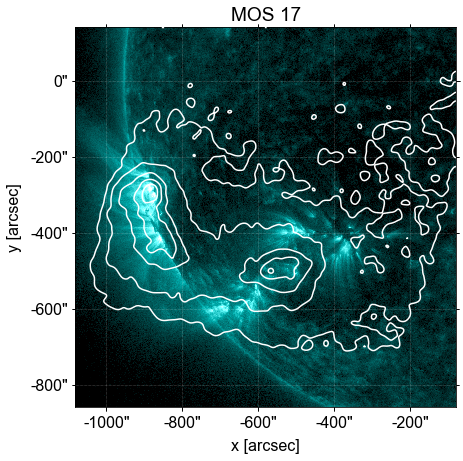

In [23]:
# CHU13 shift
wid=1000
shx=50
shy=70
ids=np.array([17])-1
for i in ids:
    nsid=nsids[i]
    hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
    evtdata=hdulist[1].data
    hdr = hdulist[1].header
    hdulist.close()
    pxs=abs(hdr['TCDLT14'])
    shevtx=round(shx/pxs)
    shevty=round(shy/pxs)
    evtdata['x']+=shevtx
    evtdata['y']+=shevty

    cevt0 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0)
    nmap0 = nustar.map.make_sunpy(cevt0, hdr,norm_map=True)
    bl=np.array([xcs[i]-0.5*wid,ycs[i]-0.5*wid])
    tr=np.array([xcs[i]+0.5*wid,ycs[i]+0.5*wid])
    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nmap0.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nmap0.coordinate_frame)
    snm = nmap0.submap(bottom_left, top_right=top_right)
    dd=ndimage.gaussian_filter(snm.data, 4, mode='nearest')
    snmd=Map(dd, snm.meta)
    # snmr=snm.resample([300, 300] * u.pixel)

    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=amm.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=amm.coordinate_frame)
    samm = amm.submap(bottom_left, top_right=top_right)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(projection=samm)
    samm.plot(norm=colors.PowerNorm(0.5,vmin=1,vmax=1e2))
    with Helioprojective.assume_spherical_screen(snmd.observer_coordinate):
        snmd.draw_contours(levels=cnt_lvl*u.percent, axes=ax, colors='white')
    ax.set_ylabel('y [arcsec]')
    ax.set_xlabel('x [arcsec]')
    ax.set_title(f'MOS {i+1:2d}')
    plt.show()

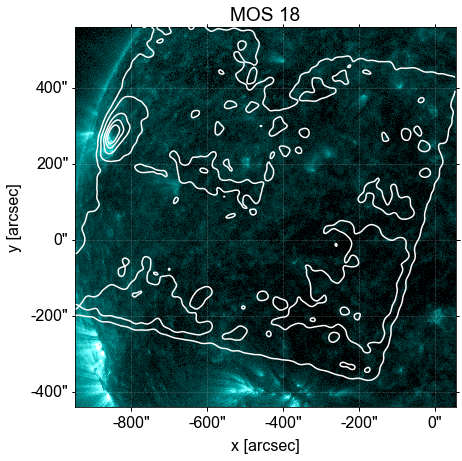

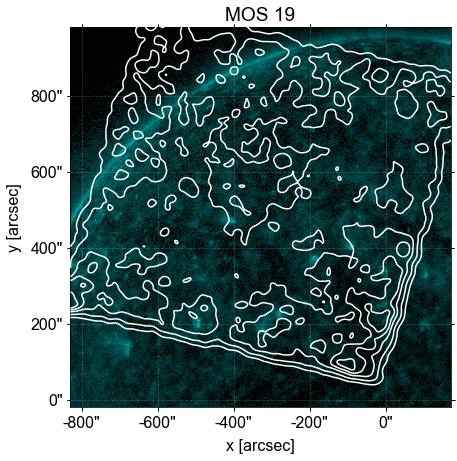

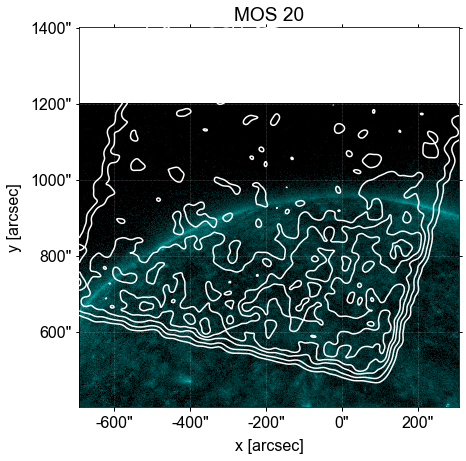

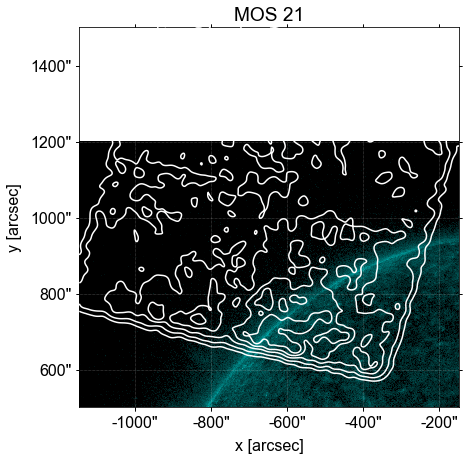

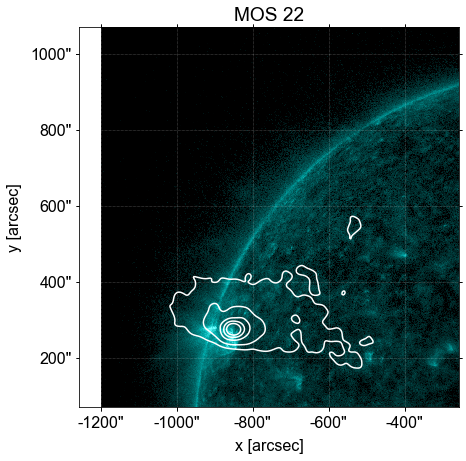

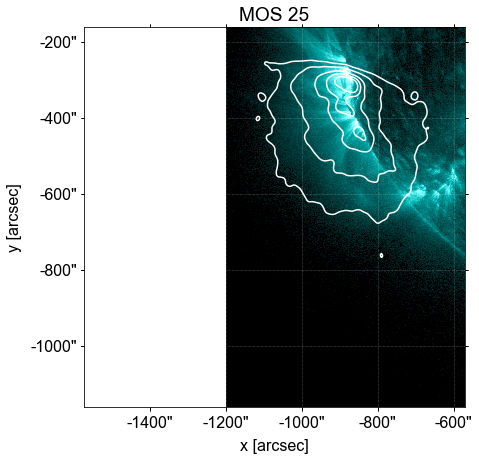

In [24]:
# CHU13 shift
wid=1000
shx=-10
shy=50
ids=np.array([18,19,20,21,22,25])-1
for i in ids:
    nsid=nsids[i]
    hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
    evtdata=hdulist[1].data
    hdr = hdulist[1].header
    hdulist.close()
    pxs=abs(hdr['TCDLT14'])
    shevtx=round(shx/pxs)
    shevty=round(shy/pxs)
    evtdata['x']+=shevtx
    evtdata['y']+=shevty

    cevt0 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0)
    nmap0 = nustar.map.make_sunpy(cevt0, hdr,norm_map=True)
    bl=np.array([xcs[i]-0.5*wid,ycs[i]-0.5*wid])
    tr=np.array([xcs[i]+0.5*wid,ycs[i]+0.5*wid])
    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nmap0.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nmap0.coordinate_frame)
    snm = nmap0.submap(bottom_left, top_right=top_right)
    dd=ndimage.gaussian_filter(snm.data, 4, mode='nearest')
    snmd=Map(dd, snm.meta)
    # snmr=snm.resample([300, 300] * u.pixel)

    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=amm.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=amm.coordinate_frame)
    samm = amm.submap(bottom_left, top_right=top_right)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(projection=samm)
    samm.plot(norm=colors.PowerNorm(0.5,vmin=1,vmax=1e2))
    with Helioprojective.assume_spherical_screen(snmd.observer_coordinate):
        snmd.draw_contours(levels=cnt_lvl*u.percent, axes=ax, colors='white')
    ax.set_ylabel('y [arcsec]')
    ax.set_xlabel('x [arcsec]')
    ax.set_title(f'MOS {i+1:2d}')
    plt.show()

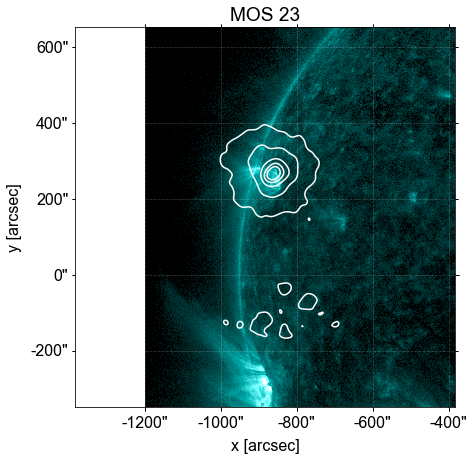

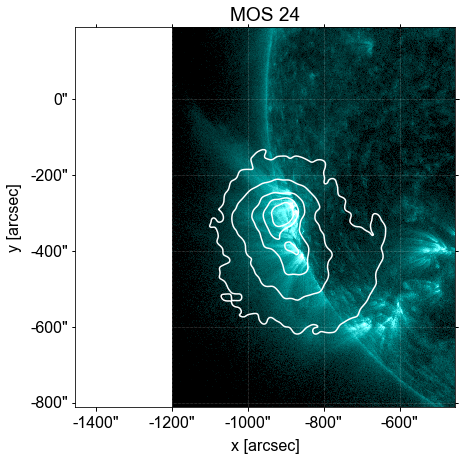

In [25]:
# CHU13 shift
wid=1000
shx=0
shy=80
ids=np.array([23,24])-1
for i in ids:
    nsid=nsids[i]
    hdulist = fits.open(maindir+nsid+'/event_cl/nu'+nsid+'A06_cl_sunpos.evt')
    evtdata=hdulist[1].data
    hdr = hdulist[1].header
    hdulist.close()
    pxs=abs(hdr['TCDLT14'])
    shevtx=round(shx/pxs)
    shevty=round(shy/pxs)
    evtdata['x']+=shevtx
    evtdata['y']+=shevty

    cevt0 = nustar.filter.event_filter(evtdata,fpm='A',energy_low=2.0, energy_high=10.0)
    nmap0 = nustar.map.make_sunpy(cevt0, hdr,norm_map=True)
    bl=np.array([xcs[i]-0.5*wid,ycs[i]-0.5*wid])
    tr=np.array([xcs[i]+0.5*wid,ycs[i]+0.5*wid])
    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=nmap0.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=nmap0.coordinate_frame)
    snm = nmap0.submap(bottom_left, top_right=top_right)
    dd=ndimage.gaussian_filter(snm.data, 4, mode='nearest')
    snmd=Map(dd, snm.meta)
    # snmr=snm.resample([300, 300] * u.pixel)

    bottom_left = SkyCoord(bl[0]* u.arcsec, bl[1] * u.arcsec, frame=amm.coordinate_frame)
    top_right = SkyCoord(tr[0] * u.arcsec, tr[1] * u.arcsec, frame=amm.coordinate_frame)
    samm = amm.submap(bottom_left, top_right=top_right)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(projection=samm)
    samm.plot(norm=colors.PowerNorm(0.5,vmin=1,vmax=1e2))
    with Helioprojective.assume_spherical_screen(snmd.observer_coordinate):
        snmd.draw_contours(levels=cnt_lvl*u.percent, axes=ax, colors='white')
    ax.set_ylabel('y [arcsec]')
    ax.set_xlabel('x [arcsec]')
    ax.set_title(f'MOS {i+1:2d}')
    plt.show()

In [26]:
#  Final shifts

shx0=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
shy0=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

shx=-120
shy=35
ids=1-1
shx0[ids]=shx
shy0[ids]=shy

shx=-110
shy=45
ids=np.array([2,9])-1
for i in ids:
    shx0[i]=shx
    shy0[i]=shy

shx=-35
shy=45
ids=np.array([3,4,5,6,7,8,10,11,12])-1
for i in ids:
    shx0[i]=shx
    shy0[i]=shy
    
shx=60
shy=80
ids=np.array([13,14,15,16])-1
for i in ids:
    shx0[i]=shx
    shy0[i]=shy

shx=50
shy=70
ids=np.array([17])-1 
for i in ids:
    shx0[i]=shx
    shy0[i]=shy   

shx=-10
shy=50
ids=np.array([18,19,20,21,22,25])-1
for i in ids:
    shx0[i]=shx
    shy0[i]=shy

shx=0
shy=80
ids=np.array([23,24])-1
for i in ids:
    shx0[i]=shx
    shy0[i]=shy
print(shx0)
print(shy0)

[-120, -110, -35, -35, -35, -35, -35, -35, -110, -35, -35, -35, 60, 60, 60, 60, 50, -10, -10, -10, -10, -10, 0, 0, -10]
[35, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 80, 80, 80, 80, 70, 50, 50, 50, 50, 50, 80, 80, 50]
